In [ ]:
  from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Ai2project '

Mounted at /content/drive
[Errno 2] No such file or directory: '/content/drive/MyDrive/Ai2project '
/content


## Importing all packages

In [ ]:
import numpy as np
import cv2
import glob
import tensorflow as tf
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D,MaxPool2D, UpSampling2D, Add, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import pickle

## Loading the data from pickle file

In [ ]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=50, resize=1, slice_=(slice(60,180),slice(60,180)),color=True)
count_people = len(faces.target_names)




### Checking the file if loaded properly

In [ ]:
print(count_people)
print(faces.target_names)

print(type(faces.images[1]))
print(faces.images.shape)

12
['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Jacques Chirac' 'Jean Chretien'
 'John Ashcroft' 'Junichiro Koizumi' 'Serena Williams' 'Tony Blair']
<class 'numpy.ndarray'>
(1560, 120, 120, 3)


## Creating numpy array of all images

### This array of images will be our reference

## Splitting into training and test data set

In [ ]:

train_x,test_x = train_test_split(faces.images/255.,random_state=32, test_size=0.2)


## Lowering the resolution of Images

### These images will be our input images for checking 

#### We'll pixalate the image without reducing the size

In [ ]:
def pixalate_image(image,scale_percent=60):
    """Lowering the image resolution
    Return value of this function is a low resolution image"""

    #lower the pixel of the image and reduce the size for the same 
    width = int(image.shape[1]*scale_percent/100)
    height = int(image.shape[0]*scale_percent/100)
    dim = (width, height)
    # print(width,height)

    small_image = cv2.resize(image,dim,interpolation=cv2.INTER_AREA)
    
    # small_image = image.reshape(1,width,height,3)

    # bringing the image back to the original size

    width = int(small_image.shape[1] *100/scale_percent)
    height = int(small_image.shape[0] *100/scale_percent)
    dim = (width,height)
    # print(width,height)

    low_res= cv2.resize(small_image,dim,interpolation=cv2.INTER_AREA)
    # low_res = small_image.reshape(1,width,height,3)

    return low_res




### Passing the images to our pixalate function

In [ ]:
#Low resolution images for the train dataset

print(train_x[1].shape[1])
print(train_x[1].shape[0])
train_x_px = []
for i in range(train_x.shape[0]):
    temp = pixalate_image(train_x[i,:,:,:])
    train_x_px.append(temp)
train_x_px=np.array(train_x_px)
print(train_x_px.shape)

#Low resolution images for the test dataset

test_x_px = []

for i in range(test_x.shape[0]):
    temp = pixalate_image(test_x[i,:,:,:])
    test_x_px.append(temp)

test_x_px = np.array(test_x_px)





120
120
(1248, 120, 120, 3)


### Checking the pixalized image

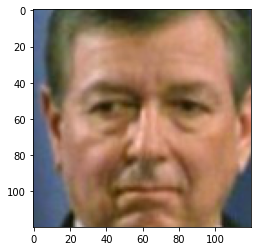

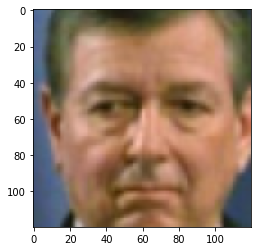

In [ ]:
plt.imshow(train_x[101])
plt.show()
plt.imshow(train_x_px[101])
plt.show()

### Quality Metrics functions


In [ ]:
#lets build the model No TPU
#with strategy.scope():
Input_img = Input(shape=( 120,120, 3))  
    
#encoding architecture
x1 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(Input_img)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x1)
x3 = MaxPool2D(padding='same')(x2)

x4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x3)
x5 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x4)
x6 = MaxPool2D(padding='same')(x5)

encoded = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x6)
#encoded = Conv2D(128, (3, 3), activation='relu', padding='same')(x2)

# decoding architecture
x7 = UpSampling2D()(encoded)
x8 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x7)
x9 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x8)
x10 = Add()([x5, x9])

x11 = UpSampling2D()(x10)
x12 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x11)
x13 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x12)
x14 = Add()([x2, x13])

# x3 = UpSampling2D((2, 2))(x3)
# x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
# x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
decoded = Conv2D(3, (3, 3), padding='same',activation='relu', kernel_regularizer=regularizers.l1(10e-10))(x14)

autoencoder = Model(Input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

## Building the model

In [ ]:
autoencoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_36 (Conv2D)             (None, 120, 120, 12  3584        ['input_4[0][0]']                
                                8)                                                                
                                                                                                  
 conv2d_37 (Conv2D)             (None, 120, 120, 12  147584      ['conv2d_36[0][0]']              
                                8)                                                          

In [ ]:
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=50, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('superResolution_checkpoint3.h5',save_best_only=True)

In [ ]:
# #Special dataset pipeline for running model on TPU
# def validation_input_fn(batch_size=1024):
#     # Convert the inputs to a Dataset.
#     dataset = tf.data.Dataset.from_tensor_slices((val_x_px, val_x))
# # Shuffle, repeat, and batch the examples.
#     dataset = dataset.cache()
#     dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)
#     dataset = dataset.repeat()
#     dataset = dataset.batch(batch_size, drop_remainder=True)
# # Return the dataset.
#     return dataset

In [ ]:
# train_x_px = np.resize(train_x,(train_x_px.shape[0],200,200,3))
# print(train_x_px.shape)
# test_x_px = np.resize(test_x_px,(test_x_px.shape[0],200,200,3))
# print(test_x_px.shape)

history = autoencoder.fit(train_x_px,train_x,
            epochs=100,
            validation_data=(test_x_px, test_x),
            callbacks=[early_stopper, model_checkpoint])

Epoch 1/100
39/39 [==============================] - 31s 594ms/step - loss: 0.1047 - accuracy: 0.7779 - val_loss: 0.0090 - val_accuracy: 0.9203
Epoch 2/100
39/39 [==============================] - 21s 535ms/step - loss: 0.0034 - accuracy: 0.9386 - val_loss: 0.0010 - val_accuracy: 0.9461
Epoch 3/100
39/39 [==============================] - 21s 536ms/step - loss: 6.8980e-04 - accuracy: 0.9590 - val_loss: 4.6387e-04 - val_accuracy: 0.9638
Epoch 4/100
39/39 [==============================] - 21s 538ms/step - loss: 3.8876e-04 - accuracy: 0.9722 - val_loss: 3.2018e-04 - val_accuracy: 0.9777
Epoch 5/100
39/39 [==============================] - 21s 540ms/step - loss: 2.9479e-04 - accuracy: 0.9787 - val_loss: 2.7990e-04 - val_accuracy: 0.9786
Epoch 6/100
39/39 [==============================] - 21s 541ms/step - loss: 2.5380e-04 - accuracy: 0.9819 - val_loss: 2.7396e-04 - val_accuracy: 0.9826
Epoch 7/100
39/39 [==============================] - 21s 541ms/step - loss: 2.5902e-04 - accuracy: 0.982

In [ ]:
autoencoder = tf.keras.models.load_model('superResolution_checkpoint3.h5')


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
predictions = autoencoder.predict(test_x_px)
print(type(predictions))
# precision = precision_score(test_x, predictions,average = "micro")
# recall = recall_score(test_x_px, test_x)
# f1_score = f1_score(test_x_px, test_x)

10/10 [==============================] - 2s 179ms/step
<class 'numpy.ndarray'>


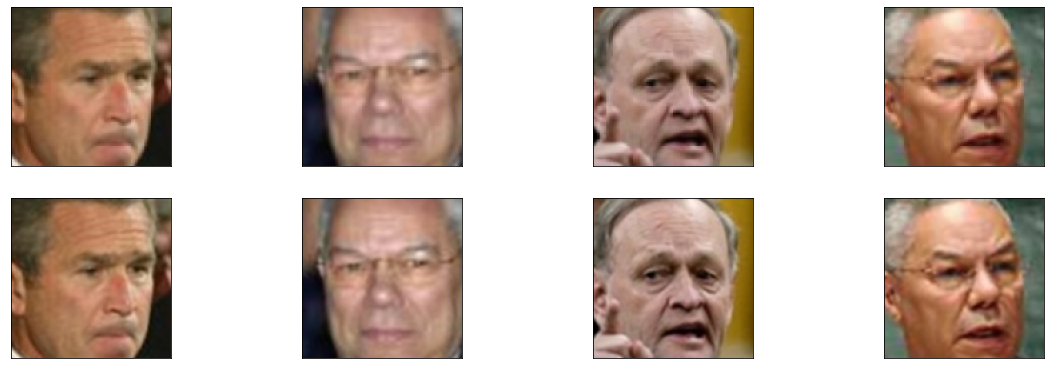

In [ ]:
n = 4
plt.figure(figsize= (20,10))

for i in range(n):
  ax = plt.subplot(3, n, i+1)
  plt.imshow(test_x_px[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(3, n, i+1+n)
  plt.imshow(predictions[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)


plt.show()

In [ ]:

results = autoencoder.evaluate(test_x_px, test_x)
print('loss, accuracy', results)
     

10/10 [==============================] - 2s 172ms/step - loss: 1.3475e-04 - accuracy: 0.9899
loss, accuracy [0.0001347513752989471, 0.989915668964386]


## Making High res dataset (img array)

In [ ]:
prediction_high_res = autoencoder.predict(faces.images/255.)
# prediction_high_res_test = autoencoder.predict(test_x)
# predicted_high_res = np.concatenate((prediction_high_res,prediction_high_res_test),axis=0)
print((prediction_high_res.shape))

49/49 [==============================] - 8s 168ms/step
(1560, 120, 120, 3)


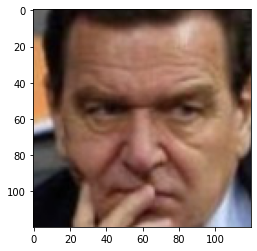

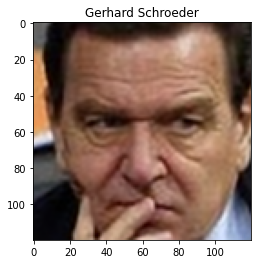

In [ ]:
plt.imshow(faces.images[1]/255.)
plt.show()
plt.imshow(prediction_high_res[1])
plt.title(faces.target_names[faces.target[1]])
plt.show()

In [ ]:
face_images = np.zeros(prediction_high_res.shape)
face_images[:] = prediction_high_res
# plt.imshow(face_images[1])
# plt.title(faces.target_names[faces.target[1]])

# print(len(faces.target_names[faces.target]))
# face_names  = []
# for i in faces.target_names[faces.target]:
  
#   face_names.append(i)

# print(len(face_names))
print((face_images.shape))


(1560, 120, 120, 3)


In [ ]:
import pandas as pd
face_names = faces.target
print(len(face_names))
yy = pd.DataFrame(face_names)
yy.columns = ["Trgt"]
FN = pd.get_dummies(yy["Trgt"], prefix='target')
face_names=np.array(FN)

print((face_names.shape))

1560
(1560, 12)


/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


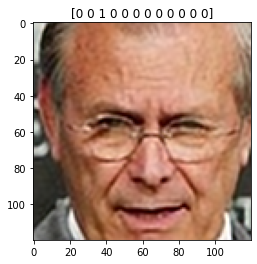

In [ ]:
plt.imshow(face_images[99])
plt.title(face_names[99])
plt.show()

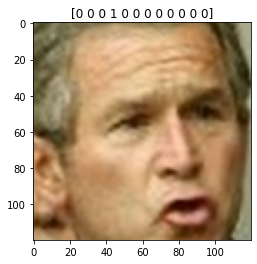

312
312


In [ ]:
#x - faces
#y - names(labels)

x_train, x_test, y_train, y_test = train_test_split(face_images, face_names, train_size=0.8,  random_state=42)
plt.imshow((x_train[0]))
plt.title((y_train[0]))
plt.show()
print(len(x_test))
print(len(y_test))


In [ ]:
from keras.models import Sequential
from keras.layers import ELU, PReLU, LeakyReLU
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='valid',input_shape=(120,120,3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='valid'))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='linear',padding='valid'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='linear',padding='valid'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(LeakyReLU(alpha=0.1))           
model.add(Dropout(0.3))
model.add(Dense(64, activation='linear'))
model.add(LeakyReLU(alpha=0.1))           
model.add(Dropout(0.3))
model.add(Dense(count_people, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50,verbose=1)
H1 = model.fit(x_train, y_train, epochs=150, batch_size=100, verbose=1, validation_split=0.1,callbacks=[callback])

Epoch 1/150
12/12 [==============================] - 1s 76ms/step - loss: 2.4570 - accuracy: 0.2404 - val_loss: 2.1514 - val_accuracy: 0.3520
Epoch 2/150
12/12 [==============================] - 1s 57ms/step - loss: 2.2615 - accuracy: 0.3215 - val_loss: 2.1690 - val_accuracy: 0.3520
Epoch 3/150
12/12 [==============================] - 1s 58ms/step - loss: 2.2148 - accuracy: 0.3304 - val_loss: 2.2271 - val_accuracy: 0.3520
Epoch 4/150
12/12 [==============================] - 1s 57ms/step - loss: 2.1644 - accuracy: 0.3366 - val_loss: 2.1585 - val_accuracy: 0.3520
Epoch 5/150
12/12 [==============================] - 1s 57ms/step - loss: 2.1716 - accuracy: 0.3348 - val_loss: 2.1505 - val_accuracy: 0.3520
Epoch 6/150
12/12 [==============================] - 1s 57ms/step - loss: 2.1394 - accuracy: 0.3357 - val_loss: 2.0744 - val_accuracy: 0.3520
Epoch 7/150
12/12 [==============================] - 1s 57ms/step - loss: 2.0972 - accuracy: 0.3357 - val_loss: 2.0717 - val_accuracy: 0.3600
Epoch 

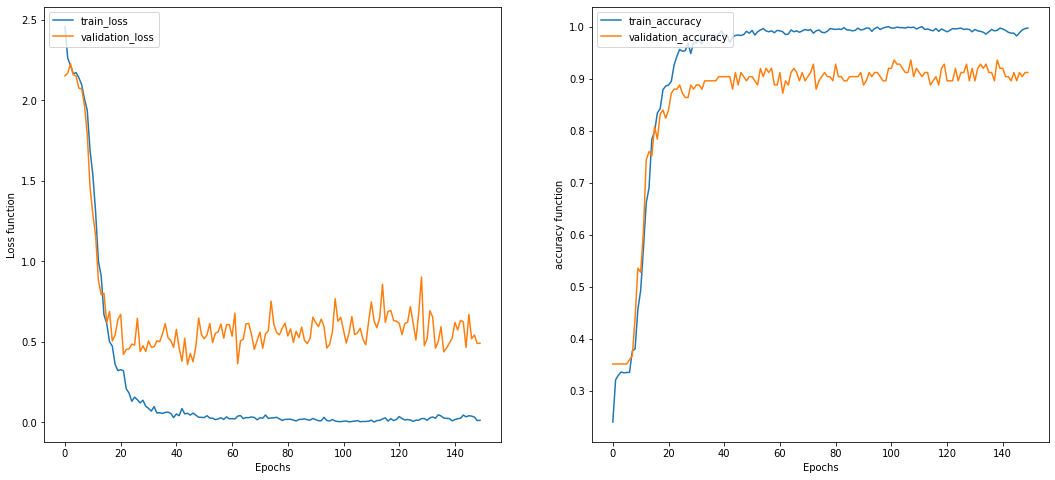

In [ ]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.plot(H1.history["loss"], label='train_loss')
plt.plot(H1.history["val_loss"], label='validation_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss function")
plt.legend(loc='upper left')
plt.subplot(1,2,2)
plt.plot(H1.history["accuracy"], label='train_accuracy')
plt.plot(H1.history["val_accuracy"], label='validation_accuracy')
plt.xlabel("Epochs")
plt.ylabel("accuracy function")
plt.legend(loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(x_test)
print("The accuracy of the predicted value from the model against the test value:", (1-np.mean(np.abs(y_pred-y_test)))*100)
loss, accuracy = model.evaluate(x_test, y_test)
print("The loss value of the test dataset", loss)
print("The accuracy value of the test dataset:", accuracy*100)

10/10 [==============================] - 0s 8ms/step
The accuracy of the predicted value from the model against the test value: 98.45743421465158
10/10 [==============================] - 0s 10ms/step - loss: 0.5578 - accuracy: 0.9135
The loss value of the test dataset 0.5577547550201416
The accuracy value of the test dataset: 91.34615659713745


In [ ]:
# n_samples, h, w = faces.images.shape
target_names = faces.target_names

y_test=np.argmax(y_test, axis=-1)
y_pred=np.argmax(y_pred, axis=-1)

y_pred.shape

(312,)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,target_names=target_names))


                   precision    recall  f1-score   support

     Ariel Sharon       0.69      0.82      0.75        11
     Colin Powell       0.89      0.91      0.90        55
  Donald Rumsfeld       0.88      0.88      0.88        25
    George W Bush       0.96      0.94      0.95       107
Gerhard Schroeder       1.00      0.95      0.98        21
      Hugo Chavez       0.80      0.86      0.83        14
   Jacques Chirac       0.71      0.71      0.71         7
    Jean Chretien       1.00      0.92      0.96        12
    John Ashcroft       1.00      1.00      1.00        12
Junichiro Koizumi       1.00      0.88      0.93         8
  Serena Williams       0.67      0.57      0.62         7
       Tony Blair       0.91      0.97      0.94        33

         accuracy                           0.91       312
        macro avg       0.88      0.87      0.87       312
     weighted avg       0.92      0.91      0.91       312



In [ ]:
!pip install visualkeras


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


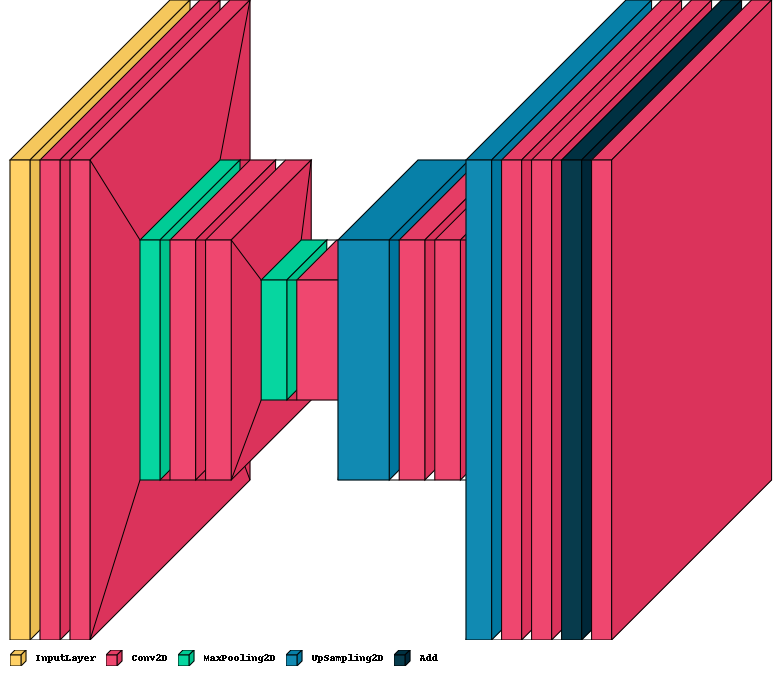

In [ ]:
import visualkeras
from google.colab.patches import cv2_imshow
visualkeras.layered_view(autoencoder, to_file='output.png',legend=True)
image = cv2.imread("output.png")
cv2_imshow(image)